In [ ]:
!pip install netCDF4
!pip install keras==2.12.0
!pip install tensorflow==2.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.12.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 100.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 44.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimat

In [ ]:
#importing tools

import pandas as pd
import numpy as np
import netCDF4 as nc
from netCDF4 import Dataset

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.lines as mlines
import seaborn as sns
import mpl_toolkits
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.lines as mlines
import seaborn as sns
import mpl_toolkits
%matplotlib inline

In [ ]:
#metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [ ]:
#Deep Learning
from keras.models import Sequential
from keras.layers import LSTM
from sklearn.decomposition import PCA
from keras.layers import Dense, Activation
from keras import optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier,KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
import tensorflow as tf

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from keras import regularizers
from keras.layers import Dropout, BatchNormalization
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
#Reading the data
copernicus_data = pd.read_csv("cuxhaven_de.csv")
copernicus_data.columns = ['time', 'wind_u10', 'wind_v10', 'slp', 'weight', 'surge']


In [ ]:
copernicus_data.head()

,time,wind_u10,wind_v10,slp,weight,surge
0,973008,9.304976,0.647637,101466.523656,1.000000,0.040876
1,973008,11.284721,0.234706,101549.947853,0.925527,0.040876
2,973008,9.304976,1.105641,101377.553920,0.668373,0.040876
3,973008,7.498699,1.067838,101748.381707,0.654728,0.040876
4,973008,7.834623,0.971875,101808.900417,0.624854,0.040876


**Data Cleaning and Preprocessing**

*We first need to find the missing values in the given data. Since no missing values were found ( The obtained data was already preprocessed in Panoply - NASA hence the lack of missing attributes.)*

*For further Preprocessing, we introduce **lag features** by including past observations for further refinment of the data.*

In [ ]:
import pandas as pd
import datetime

# This is a time lag function to create a Pandas stored time lagged series.

def time_lag(data, lags):
    """
    Transforms the dataset to a time series of grid information and returns the time-lagged time series.

    Parameters:
    - data: str, the full name of the CSV file

    Returns:
    - df_new: pd.DataFrame, time-lagged time series data
    - surge_ts: pd.DataFrame, storm surge time series data
    """
    time_orig = pd.to_datetime('1900-01-01')

    df = pd.read_csv(data)
    df.columns = ['time', 'wind_u10', 'wind_v10', 'slp', 'weight', 'surge']

    # Reorganize the matrix
    df_new = df.loc[df['weight'] == df['weight'].unique()[0]]
    df_new.drop(['weight'], axis=1, inplace=True)

    for i in range(1, 10):
        df_sub = df.loc[df['weight'] == df['weight'].unique()[i]]
        df_sub.drop(['weight', 'surge'], axis=1, inplace=True)
        df_new = pd.merge(df_new, df_sub, on='time')

    # Lag the time series data
    lagged_df = df_new.copy()
    for j in range(lags):
        lagged_df['time'] = lagged_df['time'] + 6
        lagged_df.drop(lagged_df.tail(1).index.item(), axis=0, inplace=True)
        df_new.drop(df_new.head(1).index.item(), axis=0, inplace=True)
        df_new = pd.merge(df_new, lagged_df, on='time', how='outer', suffixes=('_left', '_right'))

    df_new = df_new.T.reset_index(drop=True).T
    ind = df_new.loc[pd.isna(df_new[df_new.shape[1]-1]), :].index
    df_new.drop(ind, inplace=True)

    # Storm surge time series data
    surge_ts = pd.DataFrame(df.loc[df['weight'] == df['weight'].unique()[0]][['time', 'surge']])

    # Remove missing/NaN values
    surge_ts.reset_index(inplace=True)
    surge_ts.drop(['index'], axis=1, inplace=True)
    indx = surge_ts.loc[pd.isna(surge_ts["surge"]), :].index
    df_new.drop(indx, inplace=True)
    surge_ts.drop(indx, inplace=True)

    # Filter surge according to df_new
    lagged_time = list(df_new[0])
    time_df_new = [float(x) for x in df_new[0]]
    time_surge_ts = [float(x) for x in surge_ts['time']]
    time_both = [int(k) for k in lagged_time if (k in time_df_new) and (k in time_surge_ts)]

    surge_ts = surge_ts[surge_ts['time'].isin(time_both)]

    dt = pd.DataFrame(columns=['date'])
    for i in surge_ts.index:
        dt.loc[i, 'date'] = time_orig + datetime.timedelta(hours=int(surge_ts.loc[i, 'time']))

    surge_ts['date'] = dt
    df_new = df_new[df_new[0].isin([x*1.0 for x in time_both])]
    df_new.drop(4, axis=1, inplace=True)  # Remove the un-lagged surge data

    surge_ts.to_csv('output_surge_ts.csv', index = True)

    return df_new, surge_ts


In [ ]:
data = 'cuxhaven_de.csv'
x, surge = time_lag(data, 12)

<ipython-input-10-b26e5832a4ee>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.drop(['weight'], axis=1, inplace=True)
<ipython-input-10-b26e5832a4ee>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop(['weight', 'surge'], axis=1, inplace=True)
<ipython-input-10-b26e5832a4ee>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop(['weight', 'surge'], axis=1, inplace=True)
<ipython-input-10-b26e5832a4ee>:28: S

In [ ]:
print(surge)

        time     surge                 date
12    973080 -0.120360  2011-01-04 00:00:00
13    973086 -0.117600  2011-01-04 06:00:00
14    973092 -0.046958  2011-01-04 12:00:00
15    973098 -0.023309  2011-01-04 18:00:00
16    973104 -0.168510  2011-01-05 00:00:00
...      ...       ...                  ...
2244  986472  0.187330  2012-07-15 00:00:00
2245  986478  0.228890  2012-07-15 06:00:00
2246  986484  0.079508  2012-07-15 12:00:00
2247  986490 -0.082991  2012-07-15 18:00:00
2248  986496  0.101130  2012-07-16 00:00:00

[2237 rows x 3 columns]


**Data - Split**

*We are now going to carry out a split of the above data as testing and training data for providing a proper model evaluation.*

*We propose a training and testing data split in the ratio of 80 : 20.*

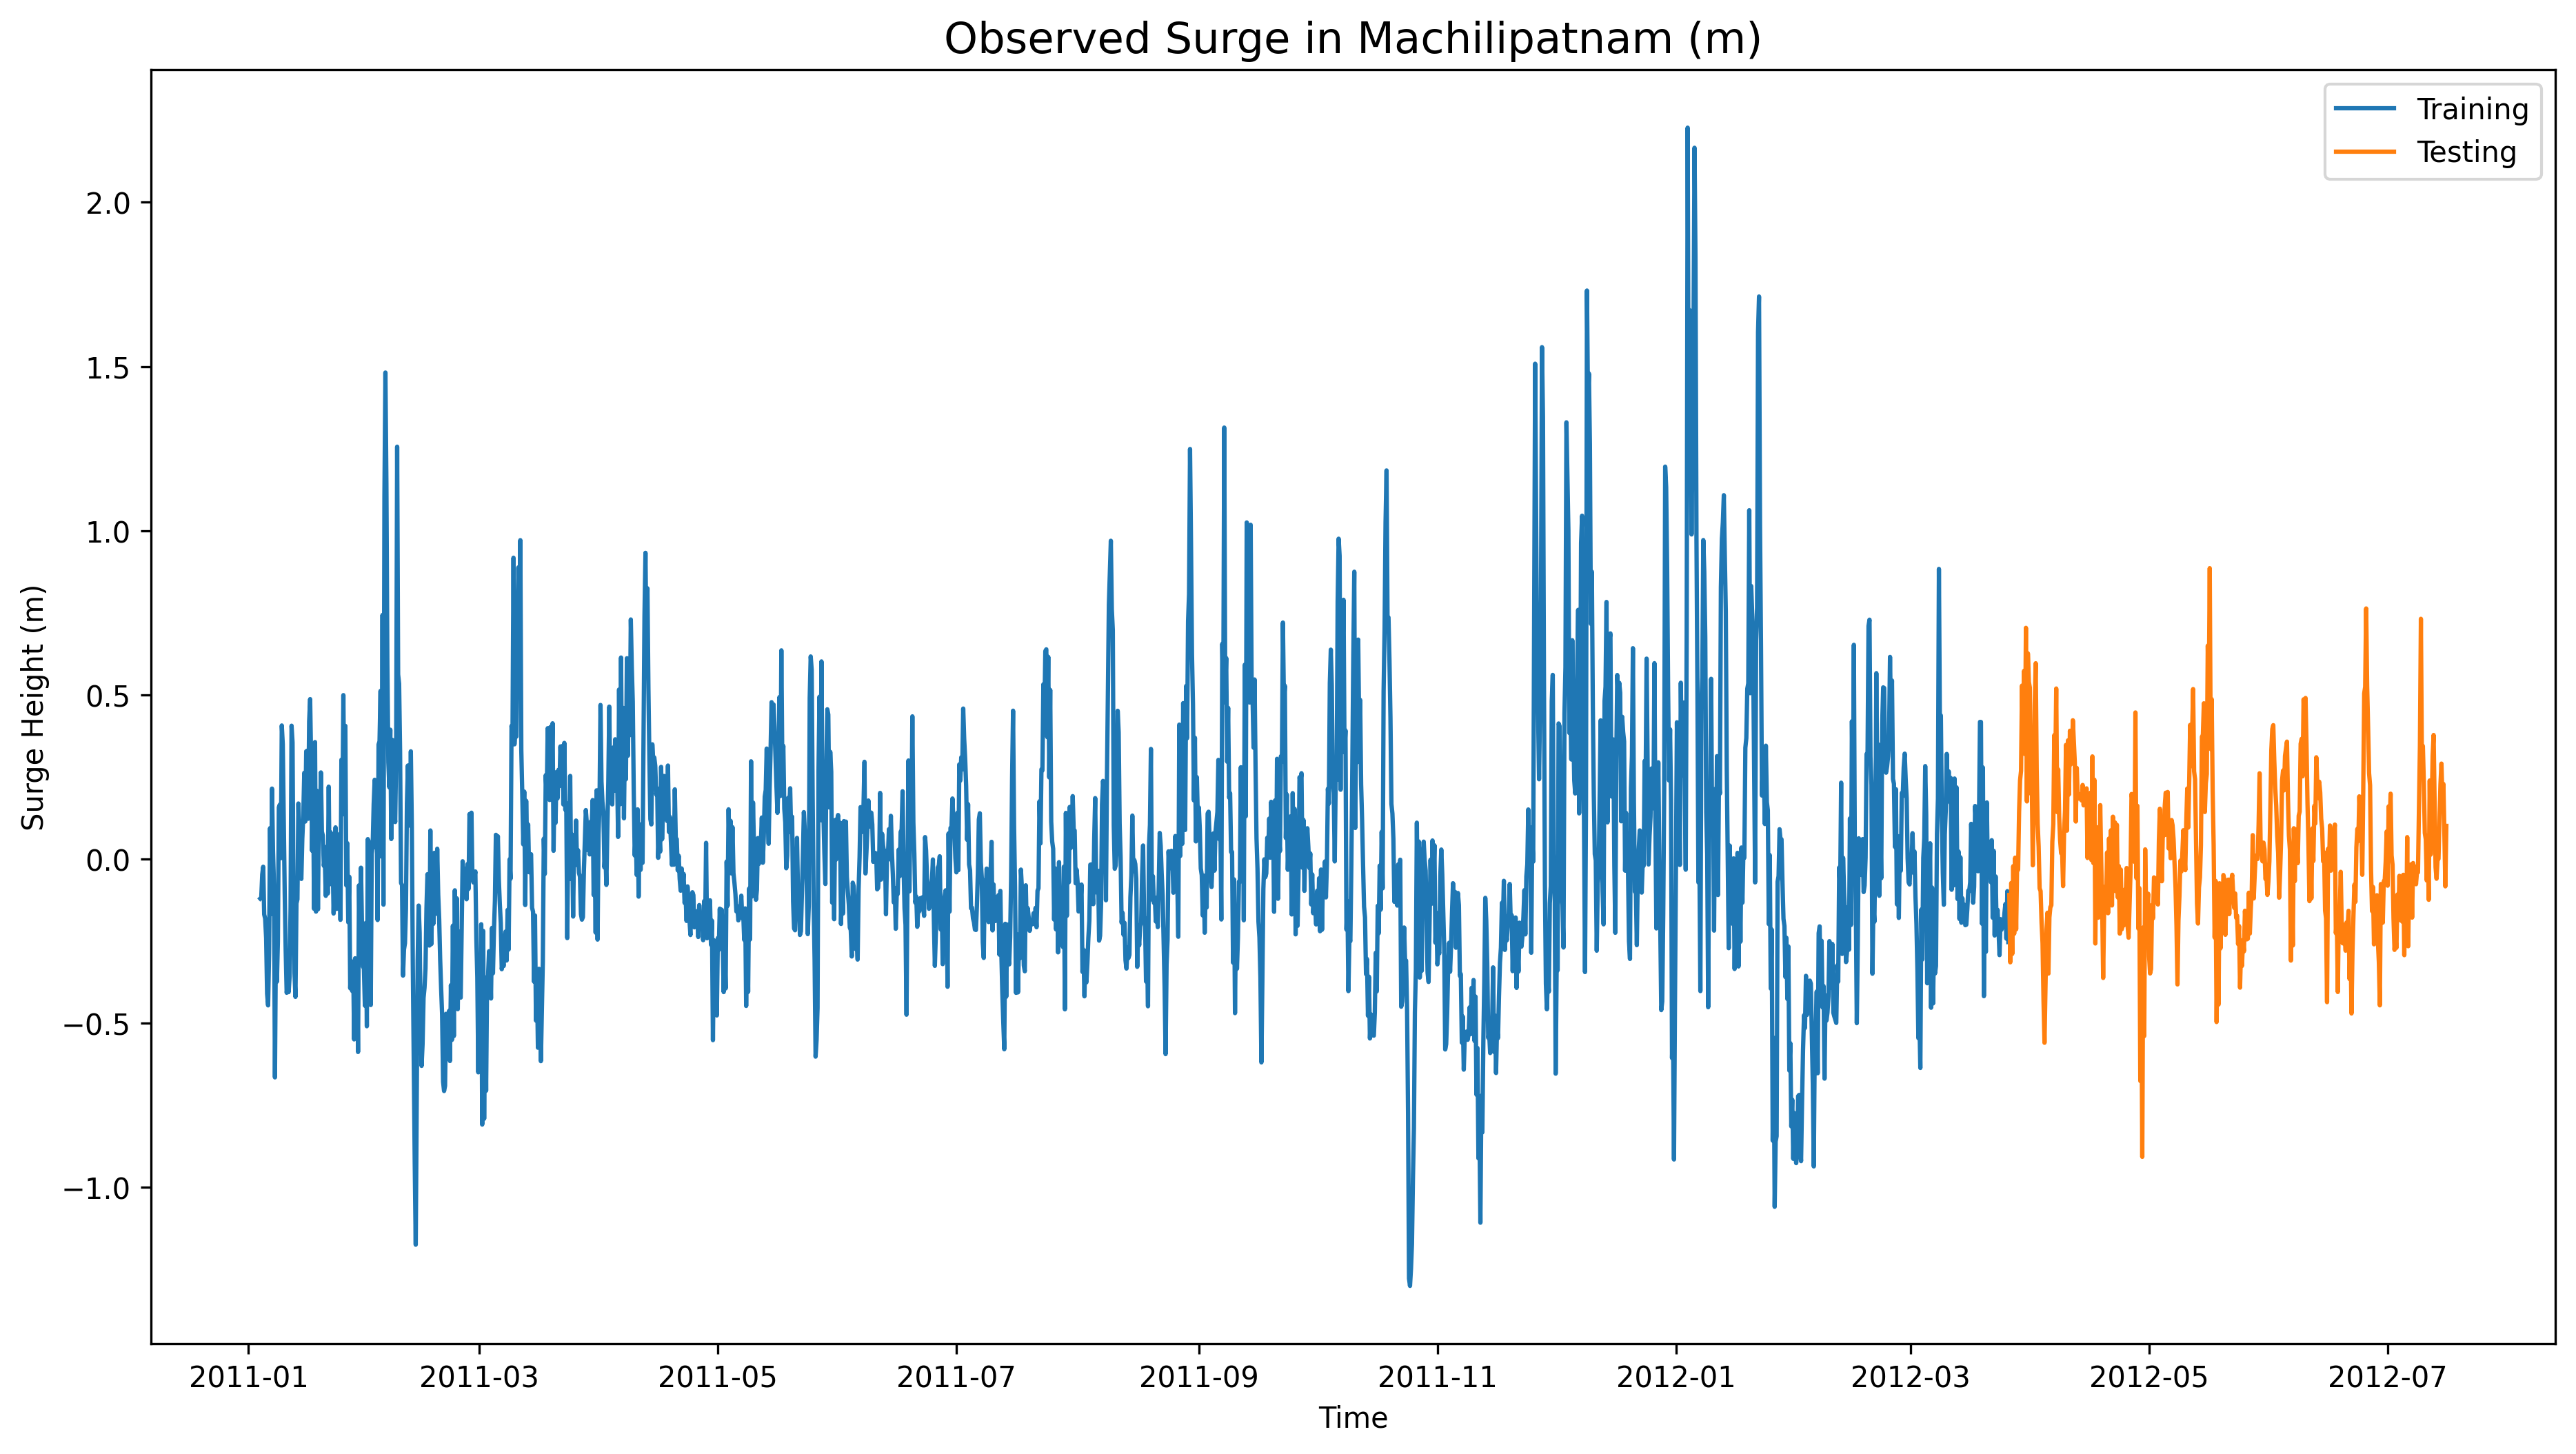

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, surge, shuffle=False, test_size=0.20, random_state=92)

# Plotting the testing-training data split.

fig = plt.subplots(figsize=(15,8), dpi=300)
plt.plot(y_train.date, y_train.surge, label="Training")
plt.plot(y_test.date, y_test.surge, label="Testing")
plt.title("Observed Surge in Machilipatnam (m)", fontsize=15)
plt.xlabel('Time')
plt.ylabel('Surge Height (m)')
plt.legend(loc='best')
plt.show()

In [ ]:
# Standardizing the features in the data-set.

x_norm_train = preprocessing.scale(x_train)
x_norm_test = preprocessing.scale(x_test)

**Linear Regression**

In [ ]:
# Linear Regression

from sklearn.linear_model import LinearRegression

def linear_regression_model(x_norm_train, x_norm_test, y_train, y_test):
    """
    Builds Linear Regression model, trains and tests it.
    """
    # Linear Regression Model
    lr_model = LinearRegression()
    lr_model.fit(x_norm_train, y_train['surge'])
    testPredict_lr = lr_model.predict(x_norm_test)

    # Model evaluation for Linear Regression
    print("Linear Regression Model:")
    print("mse = ", mean_squared_error(y_test['surge'], testPredict_lr))
    print("mae = ", mean_absolute_error(y_test['surge'], testPredict_lr))
    print("r2_score = ", r2_score(y_test['surge'], testPredict_lr))
    print()

    # Plotting for Linear Regression
    sns.set_context('notebook', font_scale=1.5)
    plt.figure(figsize=(20, 10))
    plt.plot(y_test['date'], y_test['surge'], color='blue')
    plt.plot(y_test['date'], testPredict_lr, color='red')
    plt.legend(['Observed Surge', 'Predicted Surge (Linear Regression)'], fontsize=14)
    plt.xlabel('Time')
    plt.ylabel('Surge Height (m)')
    plt.title("Observed vs. Predicted Storm Surge Height (Linear Regression)", fontsize=20, y=1.03)
    plt.savefig("linear_regression_observed_vs_predicted_surge_height.png", dpi=300)
    plt.show()

    # Scatter plot for Linear Regression
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(y_test['surge'], testPredict_lr, c='black')
    line = mlines.Line2D([0, 1], [0, 1], color='red')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    plt.show()

    return testPredict_lr


Linear Regression Model:
mse =  0.031040435527797578
mae =  0.1388056208915575
r2_score =  0.4450264710008536



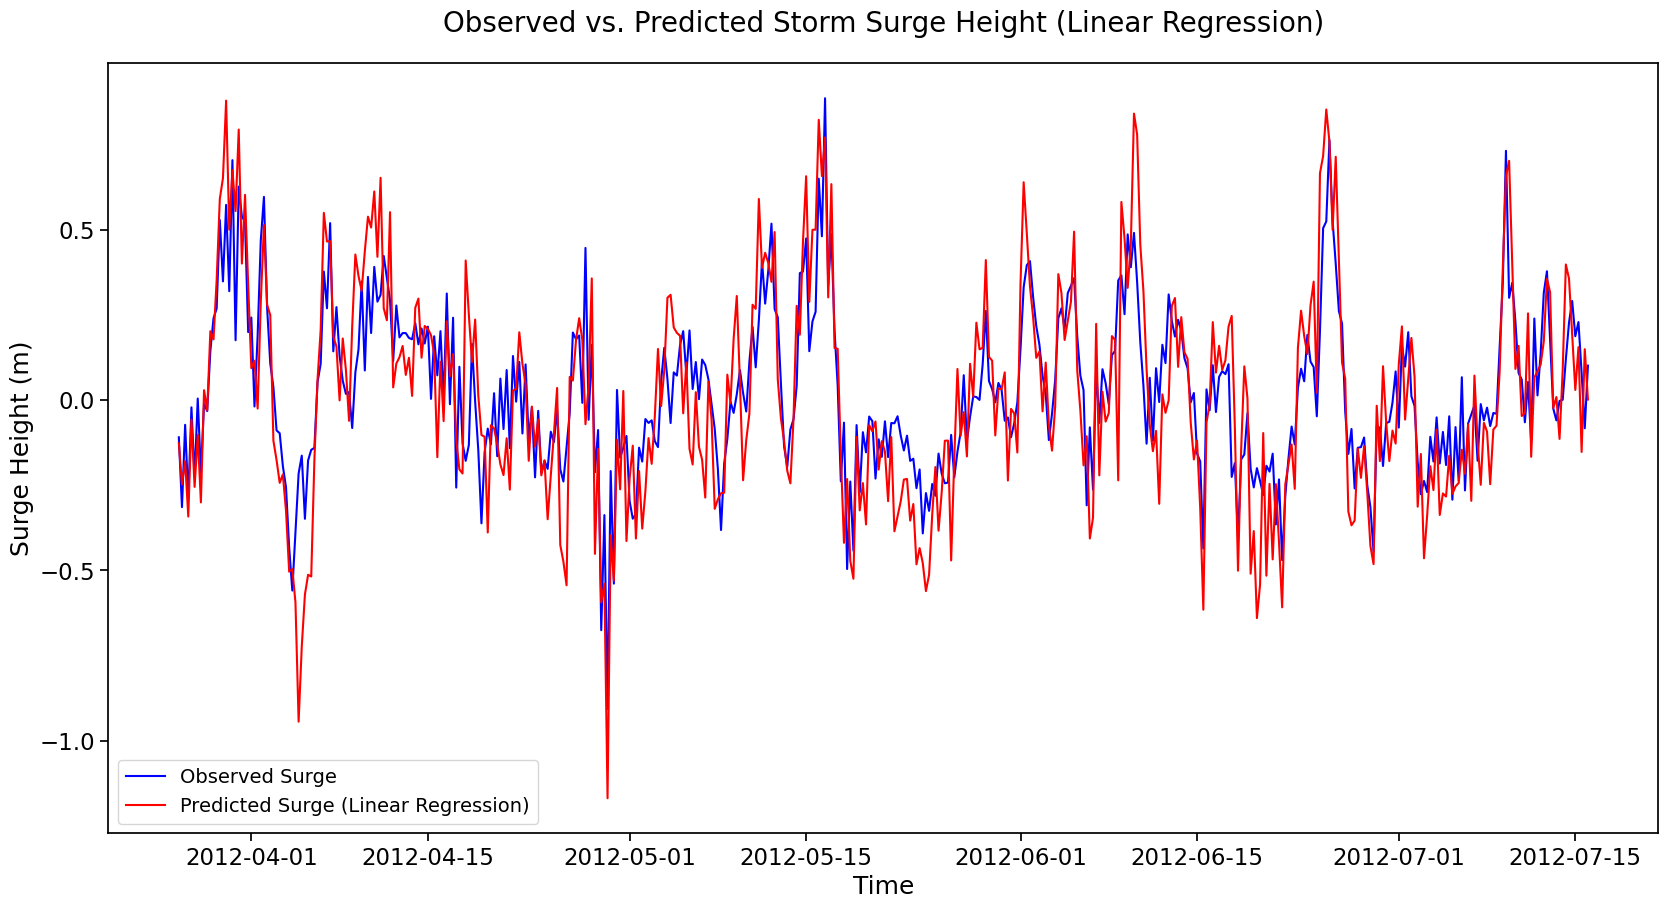

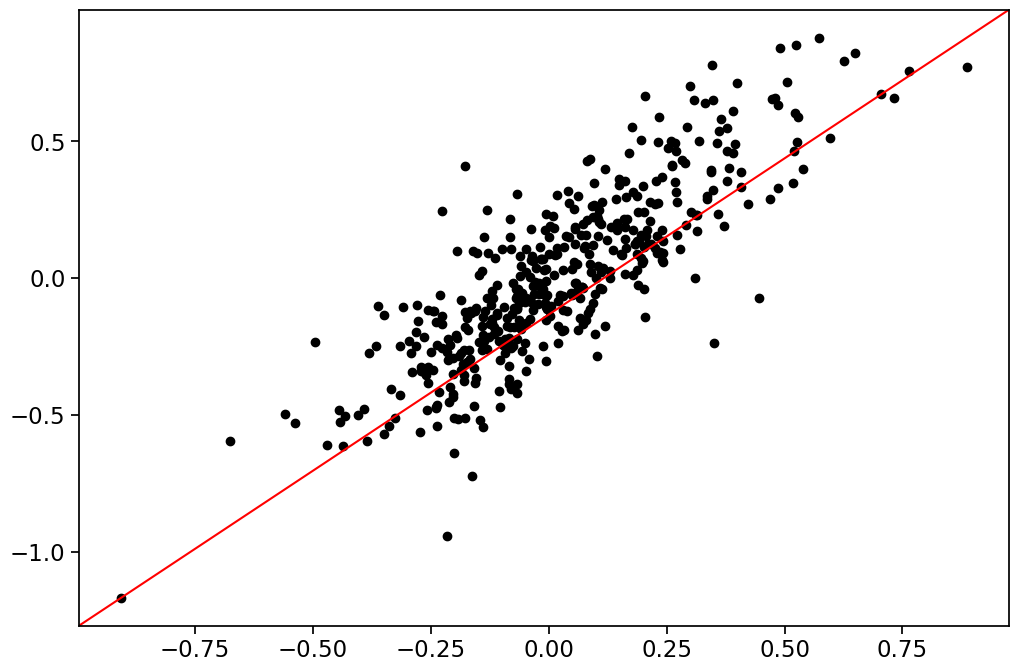

array([-1.26589423e-01, -2.47871114e-01, -1.79522012e-01, -3.42044232e-01,
       -5.72486650e-02, -2.54971472e-01, -1.02313224e-01, -3.00607670e-01,
        2.88069927e-02, -3.01831407e-02,  2.01999468e-01,  1.77929431e-01,
        3.52178828e-01,  5.90464170e-01,  6.51465611e-01,  8.79013561e-01,
        4.99946863e-01,  6.74891394e-01,  5.54630464e-01,  7.94049147e-01,
        4.00599544e-01,  6.02261959e-01,  3.37720499e-01,  9.34426744e-02,
        1.15412307e-01, -2.50273723e-02,  2.89203205e-01,  5.13686470e-01,
        2.79613056e-01,  2.49575977e-01, -1.19078023e-01, -1.76199735e-01,
       -2.43082635e-01, -2.18443942e-01, -3.25003042e-01, -5.03883051e-01,
       -4.95871368e-01, -5.94502249e-01, -9.44165490e-01, -7.23240735e-01,
       -5.70923019e-01, -5.13073449e-01, -5.17948745e-01, -1.76744705e-01,
        5.97859901e-02,  2.06455366e-01,  5.49444235e-01,  4.65331986e-01,
        4.66325714e-01,  1.86424106e-01,  1.57169763e-01, -1.02915650e-03,
        1.80686277e-01,  

In [ ]:
linear_regression_model(x_norm_train, x_norm_test, y_train, y_test)

**ARIMA**

*Autoregressive integrated moving average abbrievated as ARIMA is a statistical approach being used here to evaluate the data.*

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# fit ARIMA model
model = ARIMA(y_train['surge'], order=(20, 0, 0))
model_fit = model.fit()

# Summary
print(model_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  surge   No. Observations:                 1789
Model:                ARIMA(20, 0, 0)   Log Likelihood                 250.876
Date:                Tue, 23 Jan 2024   AIC                           -457.752
Time:                        16:02:24   BIC                           -336.985
Sample:                             0   HQIC                          -413.159
                               - 1789                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0089      0.041      0.215      0.829      -0.072       0.090
ar.L1          0.7313      0.016     44.573      0.000       0.699       0.763
ar.L2          0.3596      0.021     16.885      0.0

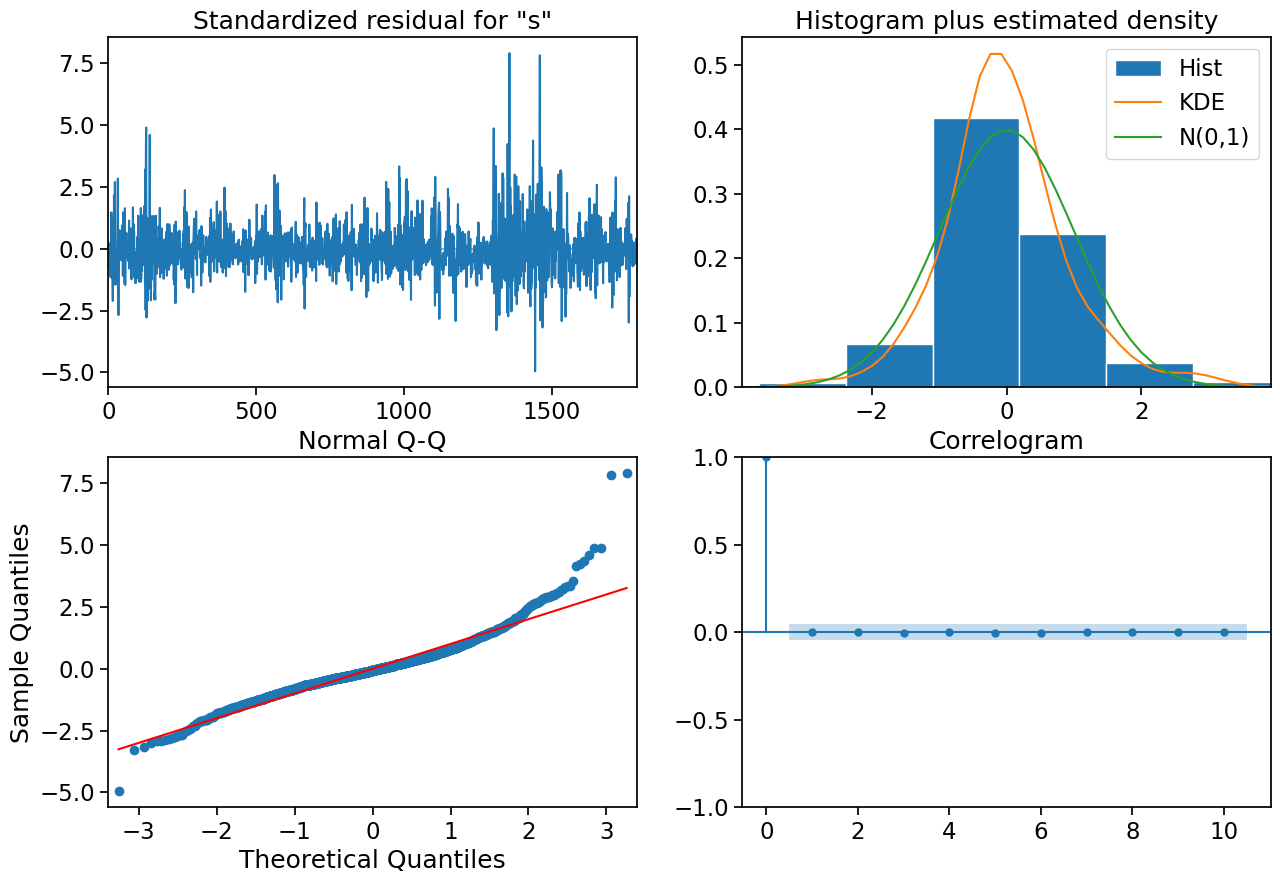

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


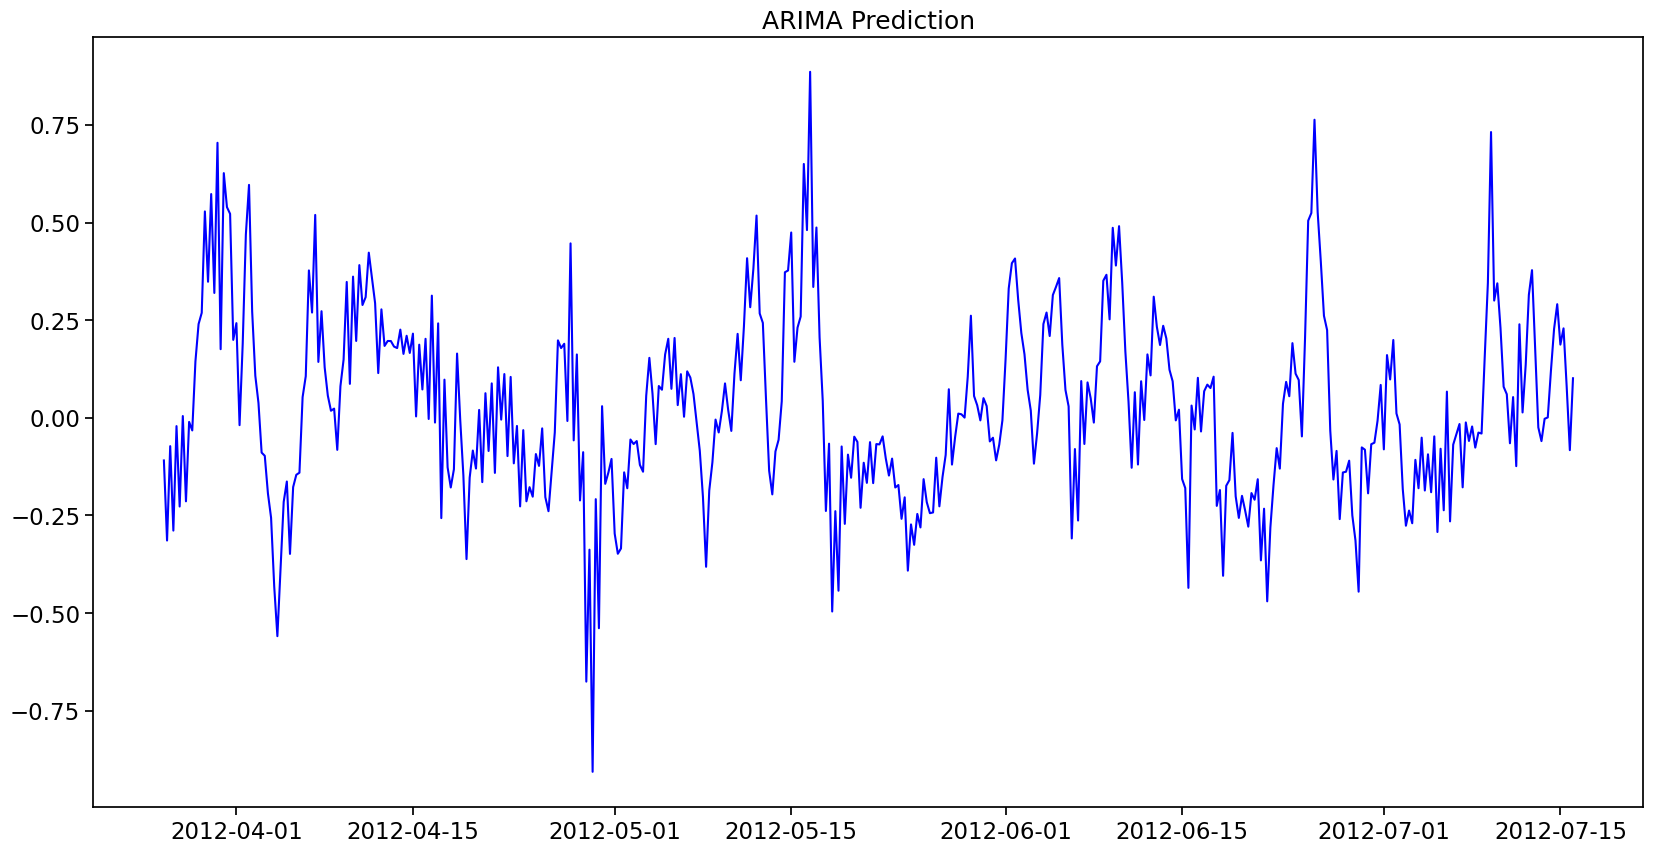

In [ ]:
# Diagnostic plots
model_fit.plot_diagnostics(figsize=(15, 10))
plt.show()

# Make predictions on the test set
arma_predictions = model_fit.forecast(steps=len(y_test))

# Plotting for ARMA
plt.figure(figsize=(20, 10))

# Plot observed data
plt.title('ARIMA Prediction')
plt.plot(y_test['date'], y_test['surge'], color='blue')


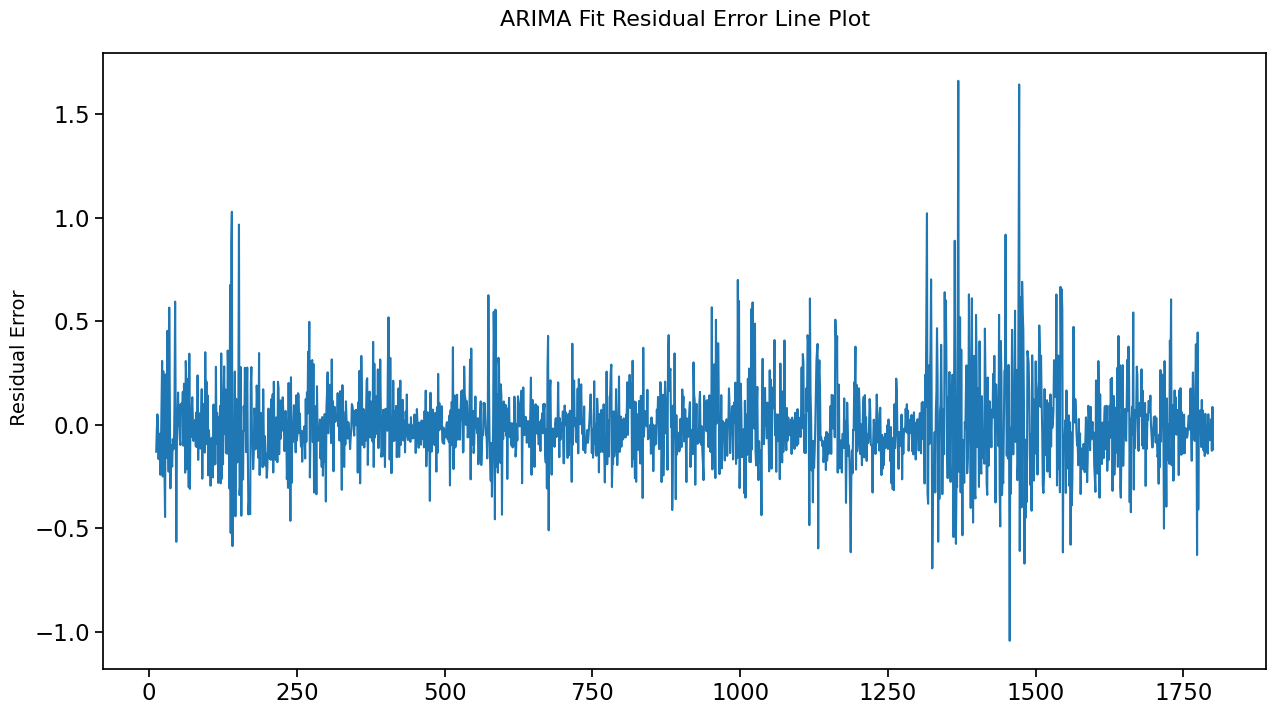

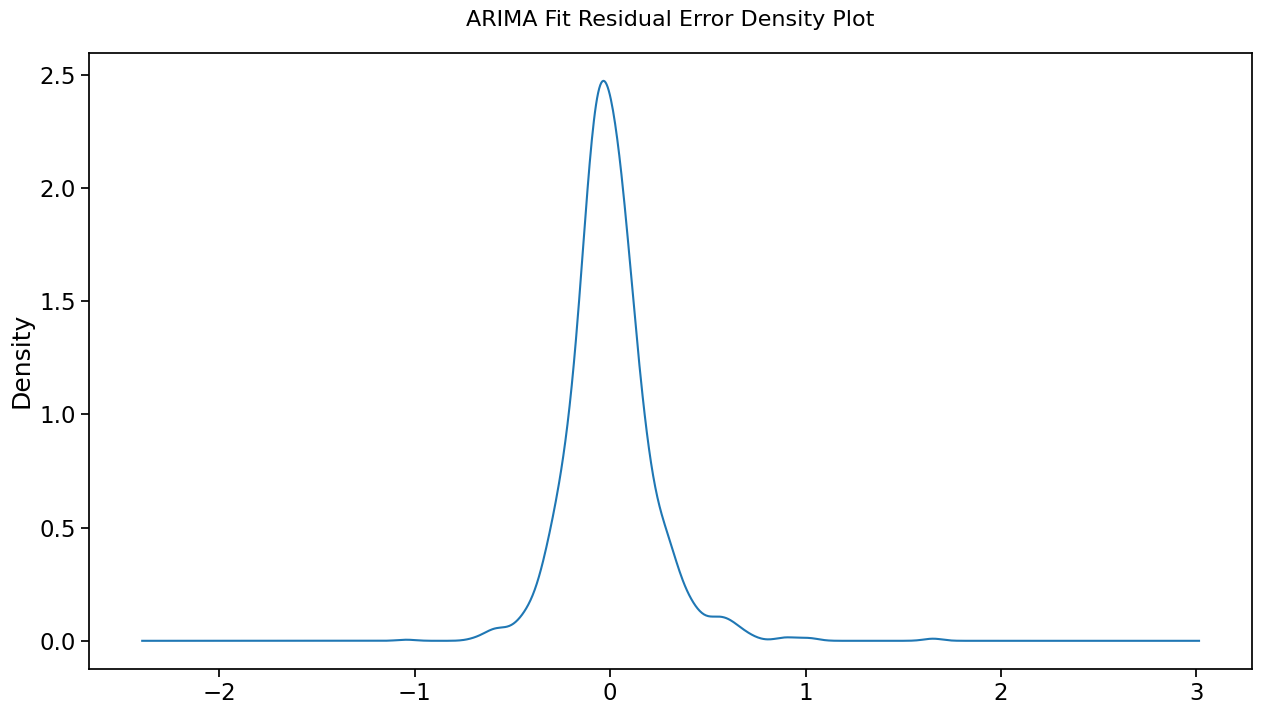

                 0
count  1789.000000
mean      0.000081
std       0.210284
min      -1.042310
25%      -0.116352
50%      -0.015031
75%       0.096792
max       1.661256


In [ ]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)

# line plot of residuals
residuals.plot(legend=None, figsize = (15, 8))
plt.ylabel(" Residual Error", fontsize=14)
plt.title("ARIMA Fit Residual Error Line Plot", fontsize=16, y=1.03)
plt.savefig("10 ARIMA Fit Residual Error Line Plot", dpi=300)
plt.show()

# density plot of residuals
residuals.plot(kind = 'kde', legend=None, figsize = (15, 8))
plt.title("ARIMA Fit Residual Error Density Plot", fontsize=16, y=1.03)
plt.savefig("11 ARIMA Fit Residual Error Density Plot", dpi=300)
plt.show()

print(residuals.describe())


Test MSE: *0.028*

In [ ]:
# forecasting
history = [x for x in y_train['surge']]
predictions = []

for t in y_test['surge'].index:
    model = ARIMA(history, order=(10, 0, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]  # Extract the forecasted value from the tuple
    predictions.append(yhat)
    obs = y_test['surge'][t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

error = mean_squared_error(y_test['surge'], predictions)

# model evaluation
print()
print("mse = ", mean_squared_error(y_test['surge'], predictions))
print("mae = ", mean_absolute_error(y_test['surge'], predictions))
print("r2_score = ", r2_score(y_test['surge'], predictions))
print()

print('Test MSE: %.3f' % error)

predicted=-0.139767, expected=-0.109360
predicted=-0.182205, expected=-0.314390
predicted=-0.170115, expected=-0.072717
predicted=-0.167504, expected=-0.288940
predicted=-0.127830, expected=-0.021407
predicted=-0.138299, expected=-0.227310
predicted=-0.071439, expected=0.004361
predicted=-0.121189, expected=-0.214010
predicted=-0.079303, expected=-0.010593
predicted=-0.118067, expected=-0.032503
predicted=0.046675, expected=0.144090
predicted=0.073422, expected=0.239860
predicted=0.215413, expected=0.268680
predicted=0.221298, expected=0.528370
predicted=0.366351, expected=0.348280
predicted=0.372539, expected=0.572870
predicted=0.337254, expected=0.319580
predicted=0.392110, expected=0.704160
predicted=0.437222, expected=0.175580
predicted=0.354684, expected=0.626460
predicted=0.289312, expected=0.539400
predicted=0.677953, expected=0.522190
predicted=0.353304, expected=0.199460
predicted=0.200950, expected=0.242270
predicted=0.169414, expected=-0.018952
predicted=0.046435, expected=0

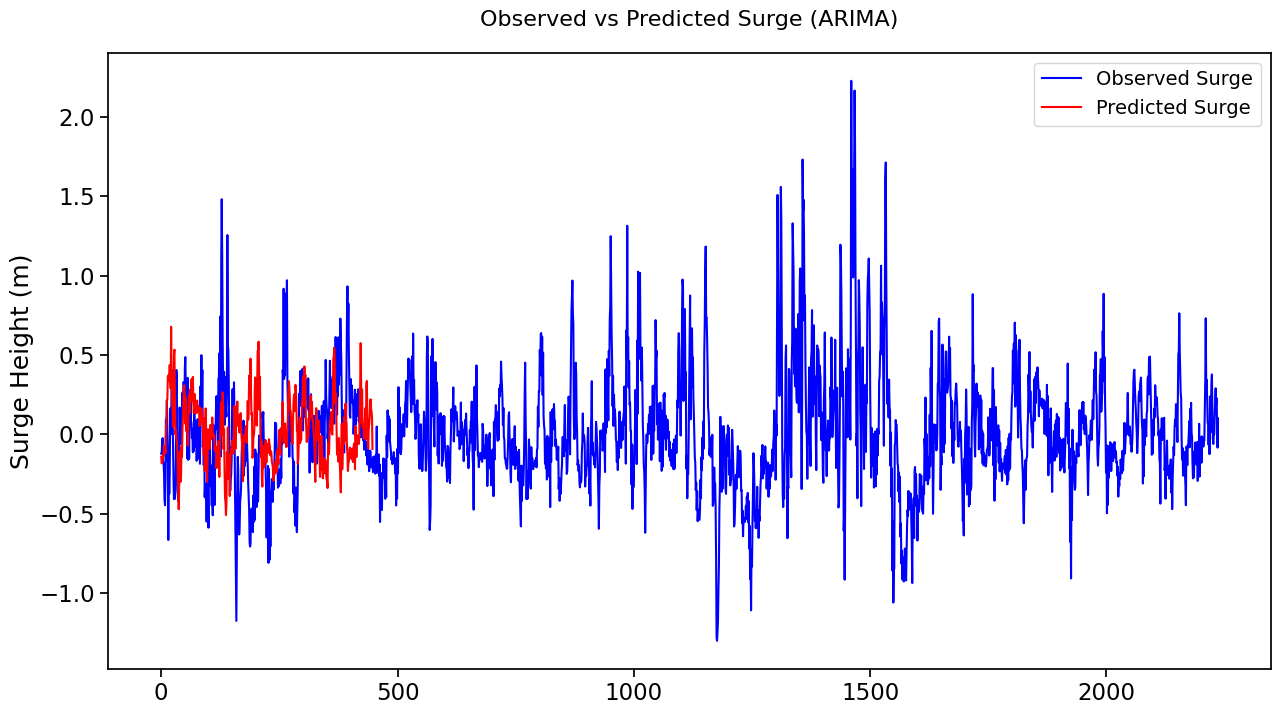

In [ ]:
sns.set_context('notebook', font_scale= 1.5)

plt.figure(figsize=(15, 8))
plt.plot(history, color='blue')
plt.plot(predictions, color= 'red')
plt.legend(['Observed Surge', 'Predicted Surge'], fontsize = 14, loc='best')
plt.ylabel('Surge Height (m)')
plt.title('Observed vs Predicted Surge (ARIMA)', fontsize=16, y=1.03)

plt.savefig("12 Observed vs Predicted Surge (ARIMA).png", dpi=300)
plt.show()

**XGBoost**

*eXtreme Gradient Boosting algorithm abbrievated as XGBoost is now being used for evaluation.*

In [ ]:
pip install xgboost


mse = 0.02361609672496048
mae = 0.12248378935155453
r2_score = 0.5777666028912695


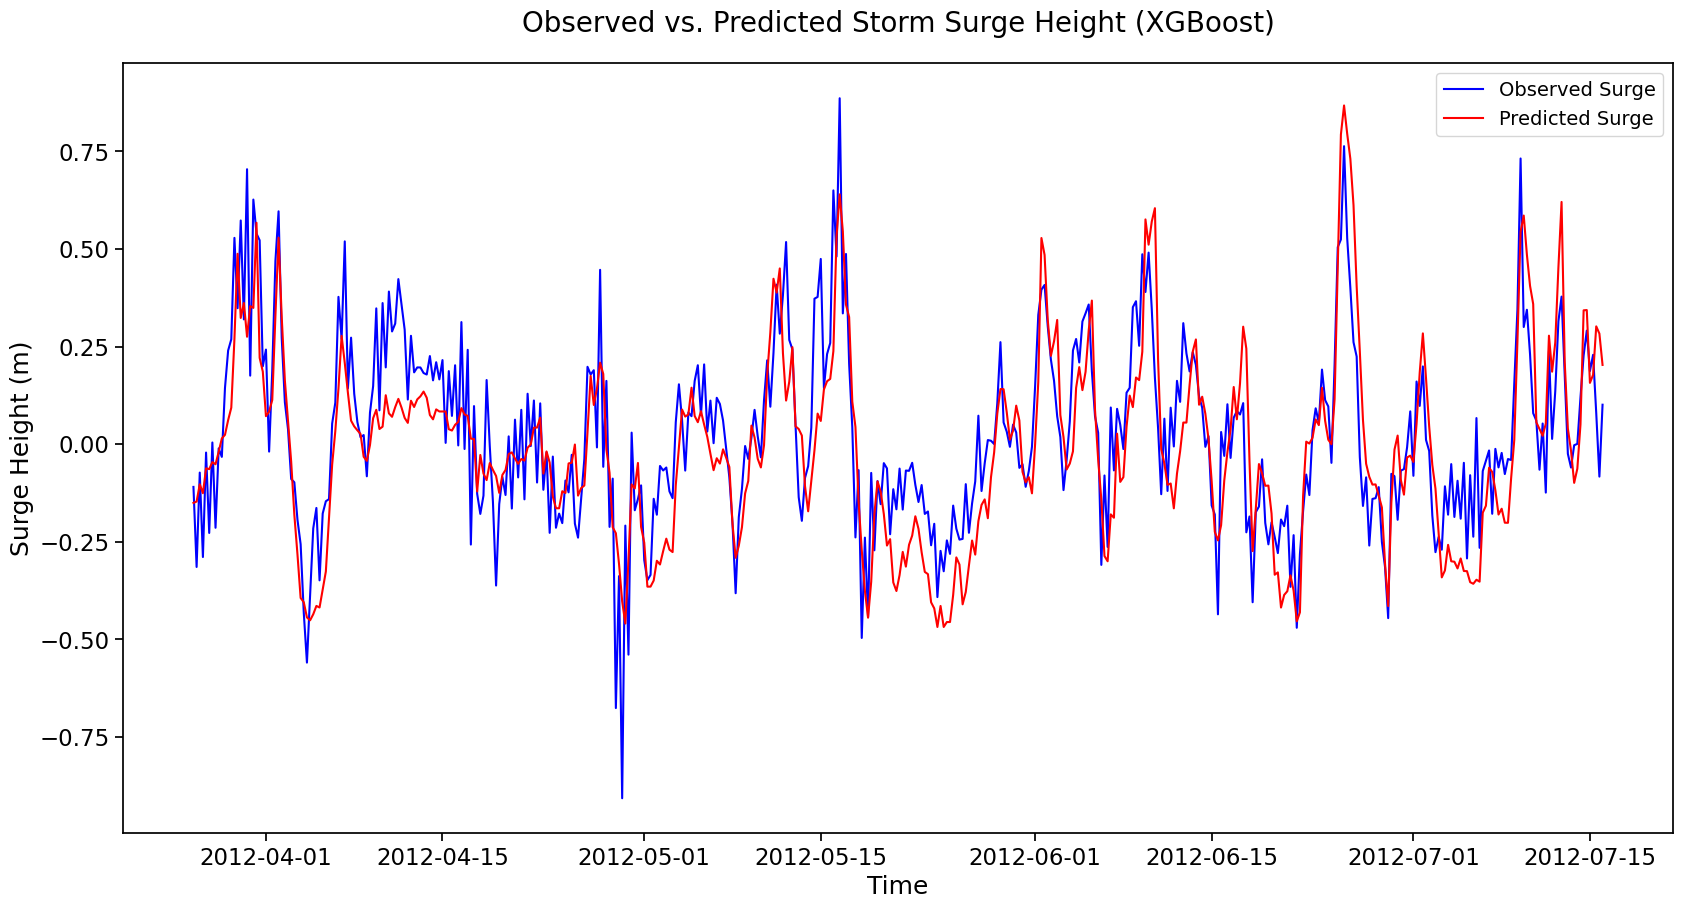

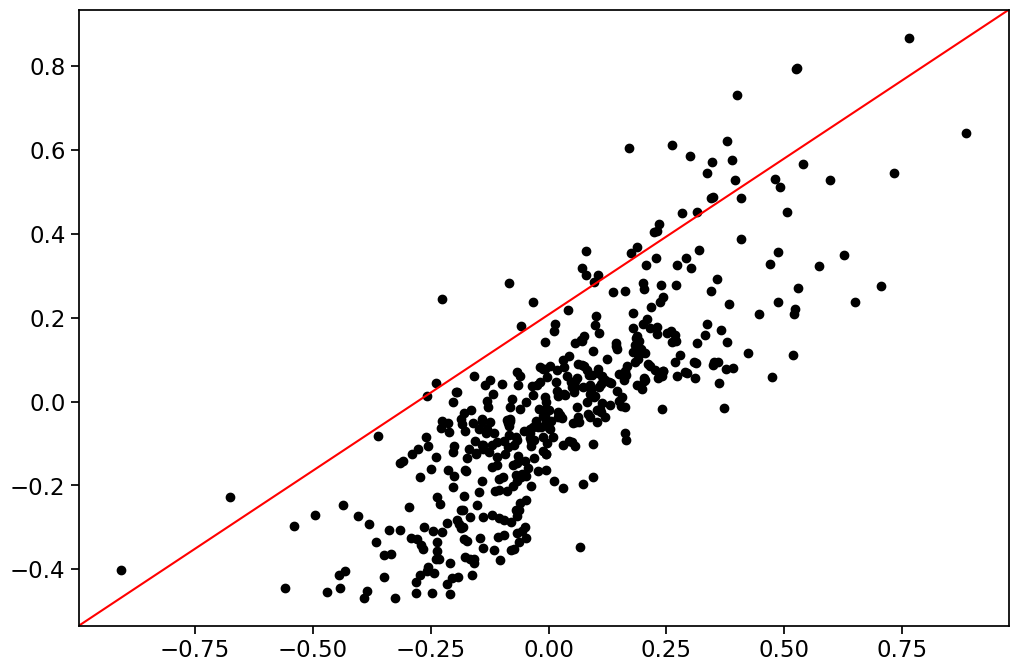

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns


# Conversion of Data Frame to Data Matrix
dtrain = xgb.DMatrix(x_norm_train, label=y_train['surge'])
dtest = xgb.DMatrix(x_norm_test, label=y_test['surge'])

# Set XGBoost parameters
params = {
    'booster' : 'gbtree',
    'objective': 'reg:squarederror',
    'colsample_bytree': 0.3,
    'learning_rate': 0.10,
    'max_depth': 5,
    'alpha': 10,
}

# Train the XGBoost model
model = xgb.train(params, dtrain, num_boost_round=30)

# Predict on test set
y_pred = model.predict(dtest)

# Model evaluation
print("mse =", mean_squared_error(y_test['surge'], y_pred))
print("mae =", mean_absolute_error(y_test['surge'], y_pred))
print("r2_score =", r2_score(y_test['surge'], y_pred))

# Plotting
sns.set_context('notebook', font_scale=1.5)
plt.figure(figsize=(20, 10))
plt.plot(y_test['date'], y_test['surge'], color='blue')
plt.plot(y_test['date'], y_pred, color='red')
plt.legend(['Observed Surge', 'Predicted Surge'], fontsize=14)
plt.xlabel('Time')
plt.ylabel('Surge Height (m)')
plt.title("Observed vs. Predicted Storm Surge Height (XGBoost)", fontsize=20, y=1.03)
plt.savefig("1 xgboost observed vs predicted surge height.png", dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y_test['surge'], y_pred, c='black')
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.show()


In [ ]:
# Conversion of Data to numerics

x_norm_train = np.asarray(x_norm_train).astype(np.int)
x_norm_test = np.asarray(x_norm_train).astype(np.int)

y_train2 = y_train.drop(['date'], axis=1)
y_test2 = y_test.drop(['date'], axis=1)

y_train2 = np.asarray(y_train2).astype(np.int)
y_test2 = np.asarray(y_test2).astype(np.int)

<ipython-input-66-176a342484b1>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_norm_train = np.asarray(x_norm_train).astype(np.int)
<ipython-input-66-176a342484b1>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated 